In [16]:
import numpy as np
import scipy as sp
import math
import torch
import matplotlib.pyplot as plt
import inspect
import textwrap

from typing import Callable
from torch import nn, optim
from data import diffeq, create_trainig_test_set

import torch.nn.functional as F

In [17]:
def f(t,x,w):
    #write the function that is on the other side of the differential equation
    return -w*x

def differential_equation_1_order(t, x, w):
    dx_dt = f(t,x,w)
    return dx_dt

def differential_equation_2_order(t, X, w):
    #rewrite d^2x/dt^2 as dy/dt where y=dx/dt
    x, y = X
    dx_dt = y
    dy_dt = f(t,x,w)

    return [dx_dt, dy_dt]

In [18]:
cooling_deq = diffeq(differential_equation_2_order, 2, 1)

train, test = create_trainig_test_set(cooling_deq, (0, 10), 100, 1000, 0.3, "RK45")
print(train["X"][0].shape)

torch.Size([103])


In [19]:
if torch.accelerator.is_available():
    device = torch.accelerator.current_accelerator().type
    print(device)

In [20]:
class CoolingModel(nn.Module):
    def __init__(self, n_step):
        super().__init__()
        self.linear = nn.Linear(in_features=n_step, out_features=200)
        self.linear2 = nn.Linear(200, 100)

    def forward(self, x):
        x = F.relu(self.linear(x))
        x = self.linear2(x)
        return x

# Initiate the model
model = CoolingModel(103)

In [21]:
loss_func = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [66]:
epochs = 100000

for epoch in range(epochs):
    T_pred = model(train["X"])
    
    loss = loss_func(T_pred, train["y_tensor"][0:, 0])

    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()

    if (epoch+1) % (int(epochs/10)) == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

Epoch 10000/100000, Loss: 0.6079
Epoch 20000/100000, Loss: 0.6250
Epoch 30000/100000, Loss: 0.6072
Epoch 40000/100000, Loss: 0.5890
Epoch 50000/100000, Loss: 0.6088
Epoch 60000/100000, Loss: 0.5928
Epoch 70000/100000, Loss: 0.6041
Epoch 80000/100000, Loss: 0.5823
Epoch 90000/100000, Loss: 0.5918
Epoch 100000/100000, Loss: 0.5975


In [67]:
model.eval()
with torch.no_grad():
    T_pred_test = model(test["X"])
    print(T_pred_test)
    test_loss = loss_func(T_pred_test, test["y_tensor"][0:, 0])
    print(f"Test Loss: {test_loss.item():.4f}")

tensor([[0.6386, 0.7323, 0.8474,  ..., 0.1475, 0.1403, 0.0841],
        [0.9684, 1.0115, 1.0264,  ..., 0.0759, 0.0824, 0.0800],
        [0.7246, 0.7405, 0.7667,  ..., 0.1328, 0.1299, 0.1373],
        ...,
        [0.3648, 0.4115, 0.5067,  ..., 0.0610, 0.0418, 0.0090],
        [0.7448, 0.7738, 0.7976,  ..., 0.0540, 0.0467, 0.0445],
        [0.6879, 0.7705, 0.8704,  ..., 0.1055, 0.0988, 0.0495]])
Test Loss: 0.6306


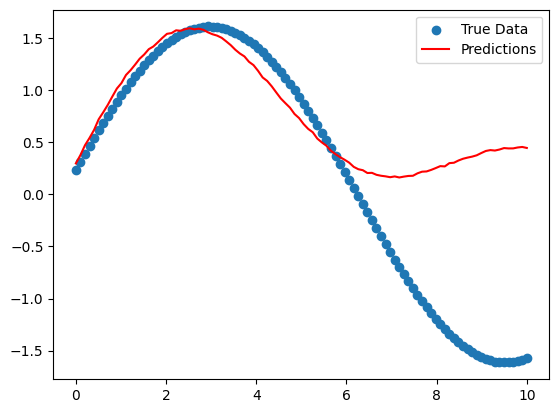

In [71]:
n = 30
plt.scatter(test["t_tensor"][n], test["y_tensor"][n][0], label="True Data")
plt.plot(test["t_tensor"][n], T_pred_test[n], color="red", label="Predictions")
plt.legend()
plt.show()